In [1]:
import numpy as np
import os

In [2]:
os.chdir("/Users/coulaud/Documents/DL-normalization")
os.getcwd()

'/Users/coulaud/Documents/DL-normalization'

In [3]:
data_dir = "data/processed/nemo_bnd_fixed/"
X      = np.load(data_dir+"train/X/NORSSH_BND_PERTEN2.npz")['arr_0']
_,H,W  = X.shape
padd_H = (H-290)//2 - 10
padd_W = (W-360)//2 - 10

In [4]:
alphas_i = X[0,padd_H:-padd_H,padd_W:-padd_W]
alphas_j = X[1,padd_H:-padd_H,padd_W:-padd_W]
w        = X[2,padd_H:-padd_H,padd_W:-padd_W]

In [184]:
alphas_i = np.rot90(alphas_i, k=1, axes=(1,0))
alphas_j = np.rot90(alphas_j, k=1, axes=(1,0))
w        = np.rot90(w       , k=1, axes=(1,0))

In [185]:
alphas_j = np.roll(alphas_j, 1, axis = 1)

In [ ]:
def crop(X):
    _,H,W  = X.shape
    if H != 310 and W != 380:
        padd_H = (H-290)//2 - 10
        padd_W = (W-360)//2 - 10
        X[0] = X[0,padd_H:-padd_H,padd_W:-padd_W]
        X[1] = X[1,padd_H:-padd_H,padd_W:-padd_W]
        X[2] = X[2,padd_H:-padd_H,padd_W:-padd_W]
        
    return X

In [ ]:
def rota_90(X):
    X = crop(X)
        
    alphas_i = np.rot90(X[0,:,:], k=1, axes=(1,0))
    alphas_j = np.rot90(X[1,:,:], k=1, axes=(1,0))
    w        = np.rot90(X[2,:,:], k=1, axes=(1,0))
    alphas_j = np.roll(alphas_j, 1, axis = 1)
    
    X    = np.empty((3,380,310))
    X[0] = alphas_j
    X[1] = alphas_i
    X[2] = w
    return X

In [ ]:
def rota_180(X):
    X = crop(X)
        
    alphas_i = np.rot90(X[0,:,:], k=2, axes=(1,0))
    alphas_j = np.rot90(X[1,:,:], k=2, axes=(1,0))
    w        = np.rot90(X[2,:,:], k=2, axes=(1,0))
    alphas_j = np.roll(alphas_j, 1, axis = 1)
    alphas_i = np.roll(alphas_i, 1, axis = 0)
    
    X    = np.empty((3,380,310))
    X[0] = alphas_i
    X[1] = alphas_j
    X[2] = w
    return X

In [5]:
def rota_270(X):
    X = crop(X)
        
    alphas_i = fliplr(X)
    alphas_j = fliplr(X)
    w        = fliplr(X)
    alphas_i = np.roll(alphas_j, 1, axis = 1)
    
    X    = np.empty((3,380,310))
    X[0] = alphas_j
    X[1] = alphas_i
    X[2] = w
    return X

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [ ]:
def flip_hor(X):
    X = crop(X)
    alphas_i = np.fliplr(X[0,:,:])
    alphas_j = np.fliplr(X[1,:,:])
    w        = np.fliplr(X[2,:,:])

    X    = np.empty((3,380,310))
    X[0] = alphas_j
    X[1] = alphas_i
    X[2] = w
    return X

In [ ]:
def flip_vert(X):
    X = crop(X)
    alphas_i = np.flipud(X[0,:,:])
    alphas_j = np.flipud(X[1,:,:])
    w        = np.flipud(X[2,:,:])

    X    = np.empty((3,380,310))
    X[0] = alphas_j
    X[1] = alphas_i
    X[2] = w
    return X

In [186]:
X    = np.empty((3,380,310))
X[0] = alphas_j
X[1] = alphas_i
X[2] = w

In [7]:
import numpy as np
import torch
from pytorch_lightning import Trainer,seed_everything,LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import src.cnn as cnn
import torchvision.transforms as transforms
import importlib
import os
import matplotlib.pyplot as plt
importlib.reload(cnn)
model = cnn.CNN.load_from_checkpoint("results/wandb/cnn/nemo_bnd_10_3k/checkpoints/epoch=3116-val_loss=0.00001.ckpt")
data_dir = "data/processed/nemo_bnd_fixed/"


/Users/coulaud/opt/anaconda3/envs/DL-normalization/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
f     = open(data_dir+"norms_std_mean.txt")
lines = f.readlines()
assert len(lines) == 2, f"len {len(lines)}"
std   = float(lines[0])
mean  = float(lines[1])
f.close()

In [45]:
Y = np.load(data_dir+"train/Y/NORSSH_BND_PERTEN2_norm_coeffs.npz")['arr_0']
Y = transforms.CenterCrop([290, 360])(torch.from_numpy(Y)).numpy()

In [10]:
X      = torch.from_numpy(X[np.newaxis,:]).float()
Y_pred = model.forward(X).detach()[0,0,:,:]*std + mean

In [11]:
mask = np.where(Y==0,True,False)
Y    = Y*std + mean
mask = np.rot90(mask, k=1, axes=(1,0))
Y    = np.rot90(Y   , k=1, axes=(1,0))

In [192]:
Y2  = np.power(Y,2)
eps = (np.power(Y_pred,2) - Y2)/Y2
eps = np.ma.masked_array(eps, mask)

print("mean: ",np.mean(np.abs(eps)[np
                                   .nonzero(eps)]))
print("max: ",np.max(eps))
print("min: ",np.min(eps))

mean:  0.7970597260633161
max:  81.65517223769528
min:  -0.9773767036794739


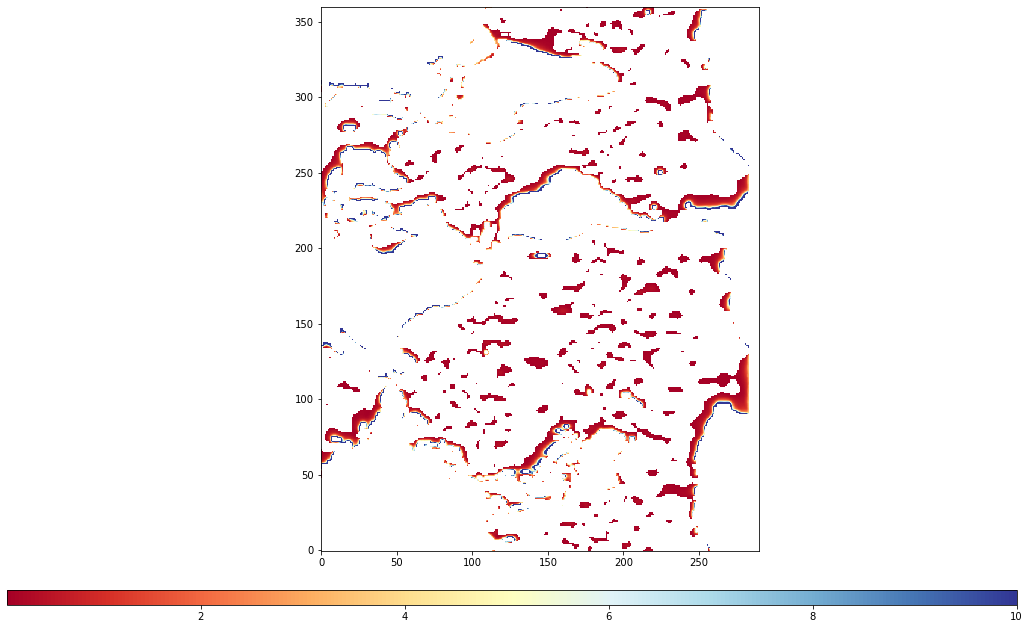

In [205]:
mask2 = np.where(eps < 0.1,True,False)
eps2 = np.ma.masked_array(eps, mask2)

fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
c = axs.imshow(eps2,origin="lower",vmin=0.1,vmax=10,cmap="RdYlBu")
cbar_ax = fig.add_axes([0.266, 0.05, 0.4673, 0.02])
plt.colorbar(c,cax=cbar_ax,orientation='horizontal')
plt.show()

### Distance map

In [126]:
Y = np.load(data_dir+"train/Y/NORSSH_BND_PERTEN2_norm_coeffs.npz")['arr_0']
Y = transforms.CenterCrop([310, 380])(torch.from_numpy(Y)).numpy()

In [127]:
Yp = np.where(Y == 0, -1, 1)
Ynew = Yp

In [128]:
H, W = Yp.shape
for i in range(H):
    for j in range(W):
        if Yp[i,j] == -1 :
            exception = False
            if H == 290:
                if Yp[(i-1) % H,j] == 1 or Yp[i, (j+1) % W] == 1 or Yp[i, (j-1) % W] == 1 :
                    Ynew[i,j] = 0
                    exception = True
            elif H == 0:
                if Yp[(i+1) % H,j] == 1 or Yp[i, (j+1) % W] == 1 or Yp[i, (j-1) % W] == 1 :
                    Ynew[i,j] = 0
                    exception = True
            
            if W == 360:
                if Yp[(i+1) % H,j] == 1 or Yp[(i-1) % H,j] == 1 or Yp[i, (j-1) % W] == 1 :
                    Ynew[i,j] = 0
                    exception = True
            
            elif W == 0:
                if Yp[(i+1) % H,j] == 1 or Yp[(i-1) % H,j] == 1 or Yp[i, (j+1) % W] == 1 :
                    Ynew[i,j] = 0  
                    exception = True
                    
            if not exception :
                if Yp[(i+1) % H,j] == 1 or Yp[(i-1) % H,j] == 1 or Yp[i, (j+1) % W] == 1 or Yp[i, (j-1) % W] == 1 :
                    Ynew[i,j] = 0

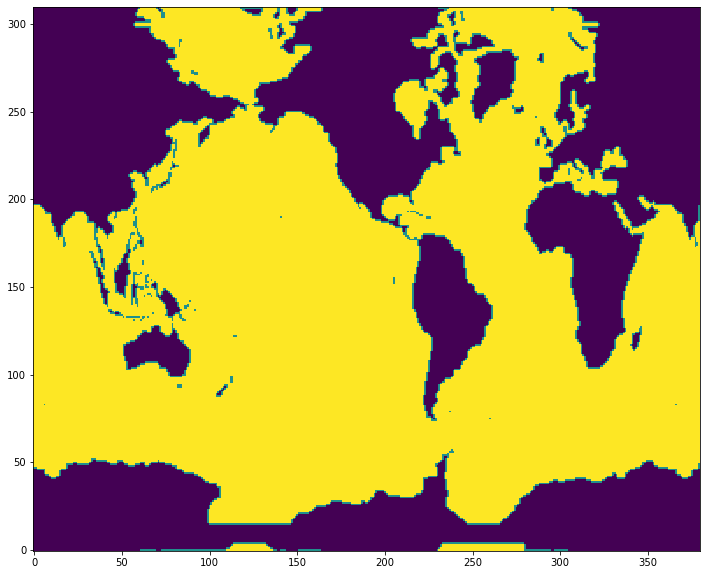

In [129]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
plt.imshow(Ynew, interpolation='none',origin="lower")
plt.show()

In [130]:
zeros = np.argwhere(Ynew == 0)
for i in range(H):
    for j in range(W):
        if Ynew[i,j] != 0:
            dist = 300 #
            for point in zeros:
                dist = min(dist, np.abs(point[0]-i)+np.abs(point[1]-j))
            Ynew[i,j] *= dist

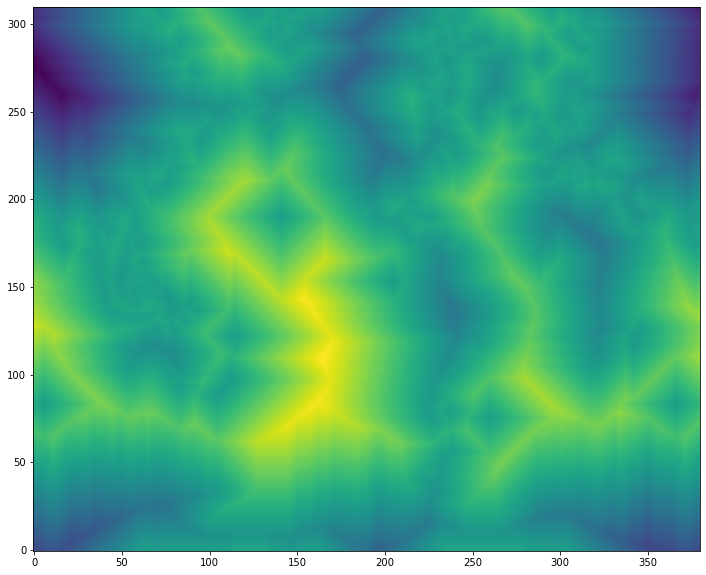

In [131]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
plt.imshow(Ynew ,origin="lower")
plt.show()

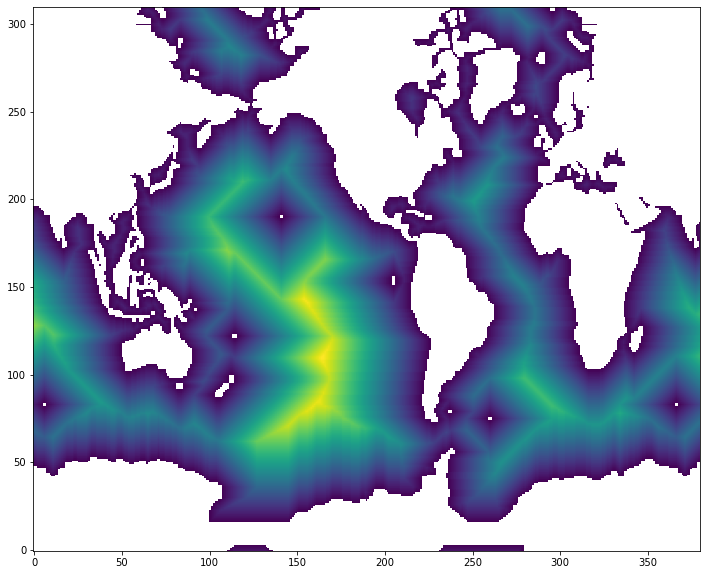

In [136]:
fig,axs = plt.subplots(figsize=(30, 10),ncols=1)
plt.imshow(np.ma.masked_array(Ynew, np.where(Y==0,True,False)) ,origin="lower")
plt.show()

In [138]:
np.save("data/sign_distance_map",Ynew)